<a href="https://colab.research.google.com/github/saritmaitra/crypto_prediction/blob/master/bitcoin_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyforest
from pyforest import *
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn.metrics
from pylab import rcParams
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
from google.colab import files

plt.style.use('ggplot')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [4]:
import pandas_datareader as web
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install yfinance

In [137]:
import yfinance as yf

btc = yf.Ticker("BTC-USD")
# get historical market data
hist = btc.history(period="max")
df = hist[['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.tail()); print(); print(df.shape)

                Open      High       Low     Close       Volume
Date                                                           
2020-08-25  11773.59  11778.30  11189.85  11366.13  26301509932
2020-08-26  11366.89  11530.05  11296.99  11488.36  22466660958
2020-08-27  11485.61  11570.79  11185.94  11323.40  23240415076
2020-08-28  11325.30  11545.62  11316.42  11542.50  19807127588
2020-08-29  11545.08  11577.64  11475.02  11475.02  18894884864

(2173, 5)


In [139]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.86,468.17,452.42,457.33,21056800
2014-09-18,456.86,456.86,413.10,424.44,34483200
2014-09-19,424.10,427.83,384.53,394.80,37919700
2014-09-20,394.67,423.30,389.88,408.90,36863600
2014-09-21,408.08,412.43,393.18,398.82,26580100


In [140]:
df.describe()

,Open,High,Low,Close,Volume
count,2173.000000,2173.000000,2173.000000,2173.000000,2.173000e+03
mean,4337.489268,4448.061431,4220.204993,4342.490152,7.744282e+09
std,4107.245418,4227.794096,3968.729128,4109.325032,1.152054e+10
min,176.900000,211.730000,171.510000,178.100000,5.914570e+06
25%,431.660000,436.020000,424.430000,431.960000,5.936640e+07
50%,3584.500000,3647.330000,3487.170000,3585.120000,1.844620e+09
75%,7836.830000,8076.890000,7615.990000,7871.690000,1.233650e+10
max,19475.800000,20089.000000,18974.100000,19497.400000,7.415677e+10


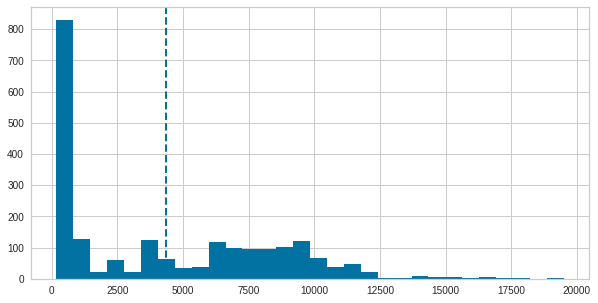

In [141]:
df['Close'].hist(bins=30, figsize=(10,5)).axvline(df['Close'].mean(), 
                                                 color='b', linestyle='dashed', linewidth=2)
plt.show()

In [119]:
fig = go.Figure(data=[go.Candlestick(x=df.index[-30:],
                                     open=df['Open'][-30:],
                                     high=df['High'][-30:],
                                     low=df['Low'][-30:],
                                     close=df['Close'][-30:])])
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title='Last 30 days BTC price', yaxis_title='BTC (US$)')
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install ta

In [129]:
# Technical Analysis library
import ta

## Technical Indicators

# Adding all the indicators
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", 
                            close="Close", volume="Volume", fillna=True)

# Dropping Open', 'High', 'Low', 'Volume' 
df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
print(df.columns);print(); print(df.shape)

Index(['Close', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'momentum_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_nvi',
       'volume_vwap', 'volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst', 'trend_kst_sig',
       'trend_kst_diff', 'trend_ichimoku_conv', 'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_

In [130]:
X = df.drop(columns = ['Close'], axis=1)
y = df.Close

# we will be keeping 30 most correlated features with 'Close' column
correlations = np.abs(X.corrwith(y))
features =  list(correlations.sort_values(ascending=False)[0:20].index)
X = X[features]
print(X.columns); print()

df = pd.concat([X, y], axis=1)
print(df.columns); 


Index(['others_cr', 'trend_ichimoku_conv', 'momentum_kama', 'trend_ema_fast', 'volatility_kcc', 'volatility_kch', 'trend_sma_fast',
       'trend_ichimoku_a', 'volatility_kcl', 'volume_vwap', 'trend_ema_slow', 'volatility_bbm', 'trend_ichimoku_base', 'volatility_bbh',
       'trend_sma_slow', 'trend_psar_down', 'trend_psar_up', 'trend_ichimoku_b', 'volatility_bbl', 'trend_visual_ichimoku_a'],
      dtype='object')



<IPython.core.display.Javascript object>

Index(['others_cr', 'trend_ichimoku_conv', 'momentum_kama', 'trend_ema_fast', 'volatility_kcc', 'volatility_kch', 'trend_sma_fast',
       'trend_ichimoku_a', 'volatility_kcl', 'volume_vwap', 'trend_ema_slow', 'volatility_bbm', 'trend_ichimoku_base', 'volatility_bbh',
       'trend_sma_slow', 'trend_psar_down', 'trend_psar_up', 'trend_ichimoku_b', 'volatility_bbl', 'trend_visual_ichimoku_a', 'Close'],
      dtype='object')


In [131]:
label_column = 'Close' # creating label
future_prediction = int(15) # prediction for next 15 days
print('length =', len(df), "and future_prediction =", future_prediction); print()

df['label'] = df[label_column].shift(-future_prediction)

print(df.head(3)); print()
print(df.tail(3));



length = 2173 and future_prediction = 15

            others_cr  trend_ichimoku_conv  momentum_kama  trend_ema_fast  volatility_kcc  volatility_kch  trend_sma_fast  trend_ichimoku_a  \
Date                                                                                                                                          
2014-09-17   0.000000              460.295     457.330000      457.330000      459.306667      475.056667      457.330000           460.295   
2014-09-18  -7.191743              440.635     442.465869      452.270000      445.386667      475.141667      440.885000           440.635   
2014-09-19 -13.672840              426.350     420.613111      443.428462      431.053333      465.323333      425.523333           426.350   

            volatility_kcl  volume_vwap  trend_ema_slow  volatility_bbm  trend_ichimoku_base  volatility_bbh  trend_sma_slow  trend_psar_down  \
Date                                                                                             

In [132]:
b = df.drop(['label', 'Close'], axis=1)
# Define features Matrix X by excluding the label column which we just created 
X = np.array(b) # dropping label from feature

X_future_prediction = X[-future_prediction:]
X = X[:-future_prediction]
print ("Length of X_future_prediction:", len(X_future_prediction), "& Length of X :", len(X)); print()

# Similarly Define Label vector y for the data we have prediction for
y = np.array(df['label'])
y = y[:-future_prediction]
print('Length of y: ',len(y)); print()

Length of X_future_prediction: 15 & Length of X : 2158

Length of y:  2158



Multiple Train-Test Splits
We are here repeating the process of splitting the time series into train and test sets multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data.

Observations: 1073
Training Observations: 538
Testing Observations: 535
Observations: 1073
Training Observations: 538
Testing Observations: 535


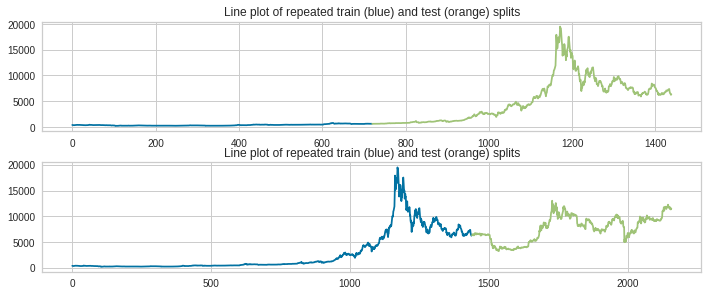


length of X_train and x_test:  1439 719



In [133]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=2)
plt.figure(figsize=(10,6))
index = 1
plt.figure(1)
index = 1
for train_samples, test_samples in tscv.split(X):
    X_train, y_train = X[train_samples], y[train_samples]
    X_test, y_test = X[test_samples], y[test_samples]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(310 + index)
    plt.plot(y_train)
    plt.plot([None for i in y_train] + [x for x in y_test])
    index += 1
    plt.tight_layout()
    plt.title('Line plot of repeated train (blue) and test (orange) splits') 

plt.show(); print();

print('length of X_train and x_test: ', len(X_train), len(X_test)); print()

In [134]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train, y_train)

from sklearn import metrics
print('Accuracy in sample:', round(model.score(X_train, y_train)*100,2).astype(str) + '%')
print('Accuracy out of sample:', round(model.score(X_test, y_test)*100,2).astype(str) + '%')

RMSE1 = np.sqrt(metrics.mean_squared_error(y_train, model.predict(X_train)));
print('RMSE train:', RMSE1); print()

RMSE2 = np.sqrt(metrics.mean_squared_error(y_test, model.predict(X_test)));
print('RMSE test:', RMSE2); print()


Accuracy in sample: 92.67%
Accuracy out of sample: 73.69%
RMSE train: 1027.8567317697637

RMSE test: 1254.7496203215035



0.7369410584934116

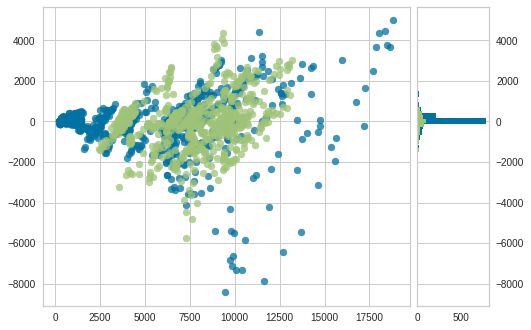

In [136]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test,y_test)  # Evaluate the model on the test data

In [114]:
forecast = pd.DataFrame(model.predict(X_future_prediction)); 

# assigning names to columns
forecast.rename(columns = {0: 'Forecast'}, inplace=True)
d = df.tail(15)
d.reset_index(inplace=True)
d = d.append(pd.DataFrame({'Date': pd.date_range(start = d.Date.iloc[-1], 
                                             periods = (len(d)+1), freq ='D', closed ='right')}))
d.set_index('Date', inplace=True)
d = d.tail(15)
forecast.index = d.index
print('Furure forecast:')
print(forecast)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Furure forecast:
                Forecast
Date                    
2020-08-30  12254.719644
2020-08-31  12403.082084
2020-09-01  12555.701980
2020-09-02  12435.293389
2020-09-03  12329.456147
2020-09-04  12373.053203
2020-09-05  12249.631195
2020-09-06  11784.229915
2020-09-07  11673.039048
2020-09-08  11697.430619
2020-09-09  11441.820681
2020-09-10  11346.332828
2020-09-11  11205.960863
2020-09-12  11259.547996
2020-09-13  11271.918361


In [106]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[-50:],y=df.Close[-50:],
                         marker=dict(color="red"), name="Actual close price"))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Forecast'],marker=dict(
        color="green"),name="Future prediction"))

fig.update_layout(title="Future Price Prediction",yaxis_title="Price (USD)",
    font=dict(family="Courier New, monospace",size=18,color="#7f7f7f"))
fig.update_layout(autosize=False,width=1000,height=400,)
fig.update_layout(legend_orientation="v")
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>